# Song Popularity

## Load the Data

Data can be found here: https://www.kaggle.com/datasets/tonygordonjr/spotify-dataset-2023?select=spotify_data_12_20_2023.csv

In [1]:
# Load the data
import pandas as pd
import numpy as np
import ast

# Note that the converters section makes it take literally twice as long to load
data: pd.DataFrame = pd.read_csv(
    "spotify_data_12_20_2023.csv",
    converters={
        "artists": ast.literal_eval,  # Makes it so that artists becomes an actual list instead of a string representation of one
        # "artist_genres": ast.literal_eval,
    },
    dtype={
        "album_name": "string",
        "name": "string",
        "track_name": "string",
        "explicit": "boolean",
        "album_type": "category",
        "genre_0": "string",
        "genre_1": "string",
        "genre_2": "string",
        "genre_3": "string",
        "genre_4": "string",
    },
    parse_dates=["release_date"],
)

if "duration_ms" in data.columns and "duration_sec" in data.columns:
    data.drop(columns=["duration_sec"], inplace=True)

# TODO: Drop rows SELECTIVELY
# print(data.isna().sum())
hardcoded_drop_columns: list[str] = [
    "rn",
    "uri",
    "track_number",
    "analysis_url",
    "track_href",
    "album_id",
    "artist_0",
    "artist_1",
    "artist_2",
    "artist_3",
    "artist_4",
    "artist_id",
    "type",
    "total_tracks",
]
data.drop(
    columns=[c for c in hardcoded_drop_columns if c in data.columns], inplace=True
)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.dropna(
    axis=0,
    subset=[
        "track_popularity",
        "tempo",
        "acousticness",
        "danceability",
        "release_year",
    ],
    inplace=True,
)

# BUG: DtypeWarning: Columns (25,26,44) have mixed types

# Professor suggestions:
####
# Split it into "model" trees
# Figure out if there are bounds where it is extremely accurate
# Find a cutoff

# Pick a random 10k instead of 300k
# Calculate a balanced accuracy
# The balanced accuracy as a function of split is a curve that peaks somewhere
# If it is smooth then you can do a binary search
####

In [ ]:
# Figure out the percentage of the track_popularities with different thresholds
cumulative_percent = 0
for i in range(50, 70):
    y = (data["track_popularity"] > i).astype(int)
    percent_popular = (y == 1).sum() / len(y) * 100
    cumulative_percent += percent_popular

    # Show the distribution of the track_popularity on the above threshold
    print(f"{i}: {percent_popular:0.2f} ({cumulative_percent:0.2f} total)")

# [40, 100] has 93% of data as "popular"
# [50, 100] has 41%
# [60, 100] has 16%
# [70, 100] has 4.3%

50: 3.54 (3.54 total)
51: 3.30 (6.84 total)
52: 3.06 (9.90 total)
53: 2.84 (12.74 total)
54: 2.63 (15.37 total)
55: 2.44 (17.81 total)
56: 2.25 (20.06 total)
57: 2.09 (22.15 total)
58: 1.93 (24.08 total)
59: 1.79 (25.87 total)
60: 1.65 (27.52 total)
61: 1.52 (29.04 total)
62: 1.39 (30.43 total)
63: 1.27 (31.70 total)
64: 1.15 (32.85 total)
65: 1.05 (33.90 total)
66: 0.96 (34.86 total)
67: 0.87 (35.73 total)
68: 0.78 (36.51 total)
69: 0.70 (37.21 total)


In [2]:
# Tokenize genres
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

if "genres" not in data.columns:
    data["genres"] = (
        data[["genre_0", "genre_1", "genre_2", "genre_3", "genre_4"]]
        .fillna("")
        .agg(" ".join, axis=1)
    )

    data.drop(
        columns=["genre_0", "genre_1", "genre_2", "genre_3", "genre_4"], inplace=True
    )

NUM_SVD_COMPONENTS = 10
TFIDF_PICKLE_PATH = "tfidf.pkl"
SVD_PICKLE_PATH = "svd.pkl"
tfidf = TfidfVectorizer(max_features=1000)
svd = TruncatedSVD(n_components=NUM_SVD_COMPONENTS, random_state=2)
tfidf_vectors = None
decomposed_tfidf = None
if os.path.exists(TFIDF_PICKLE_PATH) and os.path.exists(SVD_PICKLE_PATH):
    # Load the pickle
    with open(TFIDF_PICKLE_PATH, "rb") as tfidf_file:
        tfidf_vectors = pickle.load(tfidf_file)
    with open(SVD_PICKLE_PATH, "rb") as svd_file:
        decomposed_tfidf = pickle.load(svd_file)
else:
    # Create vectors and save the pickle
    tfidf_vectors = tfidf.fit_transform(data["genres"])
    decomposed_tfidf = svd.fit_transform(tfidf_vectors)
    with open(TFIDF_PICKLE_PATH, "wb") as tfidf_file:
        pickle.dump(tfidf_vectors, tfidf_file)
    with open(SVD_PICKLE_PATH, "wb") as svd_file:
        pickle.dump(decomposed_tfidf, svd_file)

assert tfidf_vectors is not None, "Failed to load tfidf pickle!"
assert decomposed_tfidf is not None, "Failed to load decomposed tfidf pickle!"

for i in range(decomposed_tfidf.shape[1]):
    data[f"genre_vector_{i}"] = decomposed_tfidf[:, i]

In [ ]:
assert data is not None

x = data.select_dtypes(include="number").drop(
    columns=["track_popularity"]
)

# TODO: Train the track_popularity number
y = (data["track_popularity"] > 50).astype(int)

# Show the distribution of the track_popularity on the above threshold
print(y.value_counts(normalize=True))

track_popularity
0    0.964604
1    0.035396
Name: proportion, dtype: float64


## Baseline Model

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    root_mean_squared_error,
    roc_auc_score,
    accuracy_score,
)
import matplotlib.pyplot as plt

assert data is not None

# No MAX_DEPTH leads to higher accuracy (0.6361 -> 0.9147), but it has a lower AUC (0.7587 -> 0.5767)
# My guess is, overfitting with no max depth.
MAX_DEPTH: int | None = 7
dt = DecisionTreeClassifier(
    max_depth=MAX_DEPTH,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=x.size,
    max_features="sqrt",
    class_weight="balanced",  # Make the 1's have more hold
)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=x.size
)
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)
y_pred_proba = dt.predict_proba(x_test)[:, 1]  # type: ignore

accuracy = accuracy_score(y_test, y_pred)
area_under_curve = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:0.4f}")
print(f"Area Under Curve: {area_under_curve:0.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):0.4f}")


FEATURE = "loudness"
assert FEATURE in x.columns

# Random sample the data for visualization
SAMPLE_SIZE = min(3000, len(x_test))
sample_index = np.random.choice(len(x_test), size=SAMPLE_SIZE, replace=False)

x_sample = x_test.iloc[sample_index]
y_sample = y_test.iloc[sample_index]
y_pred_sample = y_pred[sample_index]
print(y_pred_sample)

Accuracy: 0.9033
Area Under Curve: 0.9675
RMSE: 0.3109
[0 1 0 ... 0 0 0]


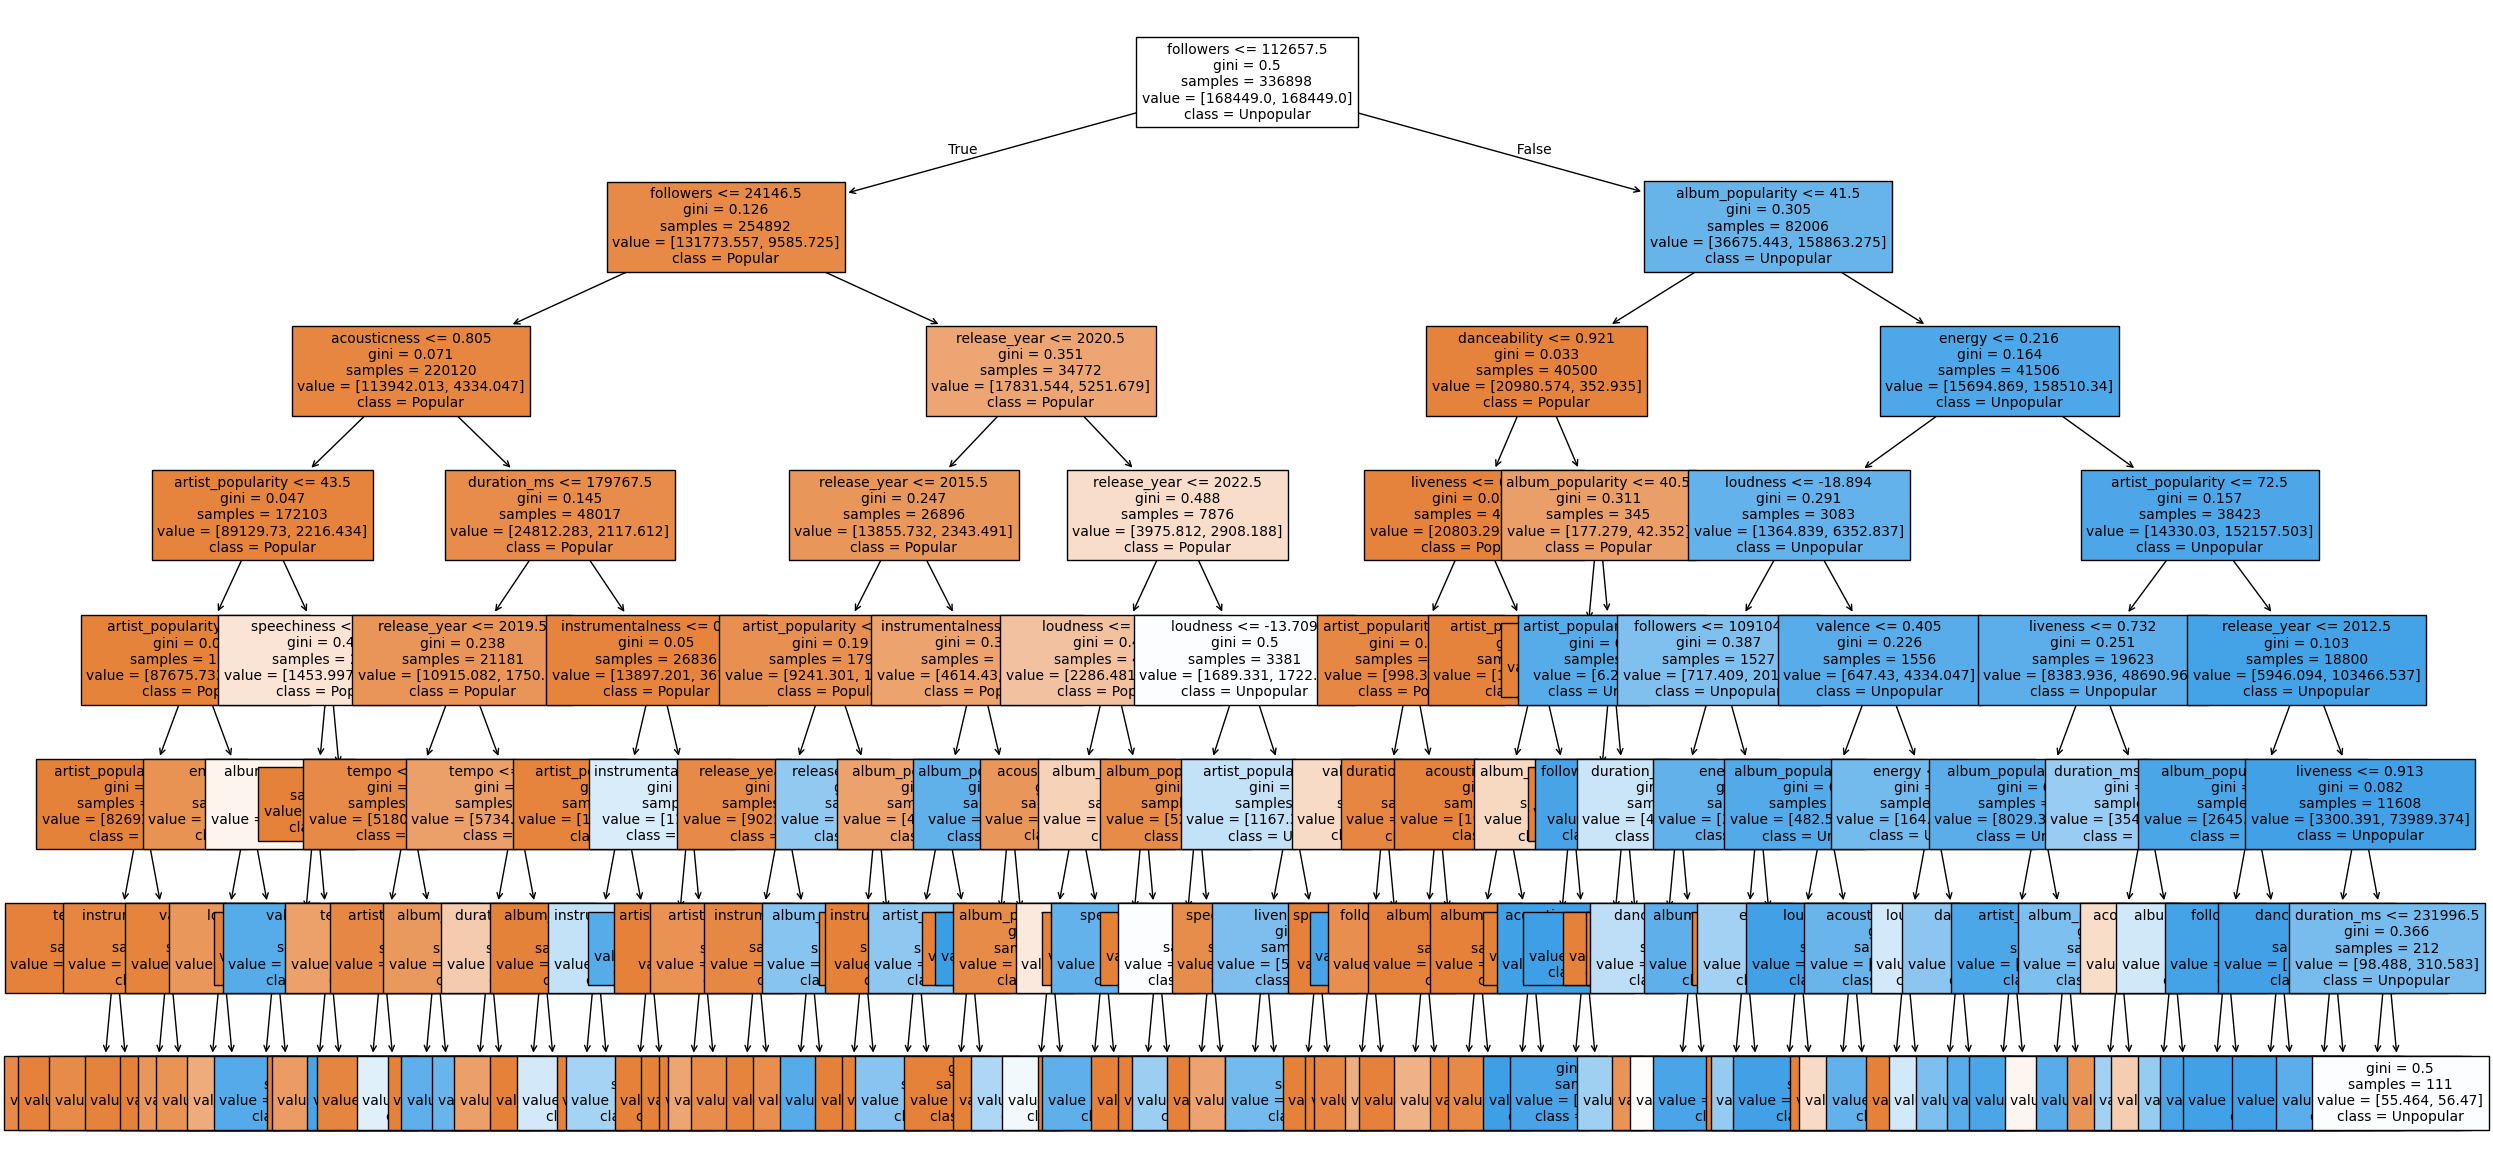

In [7]:
from sklearn.tree import plot_tree, export_graphviz

plt.figure(figsize=(30, 15))
# TODO: I'm not sure the order in which Popular/Unpopular should be
# They are DIFFERENT between the export and this one
plot_tree(
    dt,
    feature_names=x.columns.tolist(),
    class_names=["Popular", "Unpopular"],
    fontsize=10,
    filled=True,
)
plt.show()

EXPORT_DT = False
if EXPORT_DT:
    export_graphviz(
        dt,
        out_file="decision_tree.dot",
        feature_names=x.columns.tolist(),
        class_names=["Popular", "Unpopular"],
        filled=True,
    )


<Figure size 640x480 with 0 Axes>

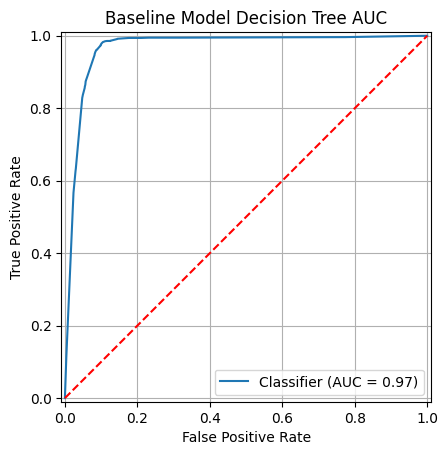

In [9]:
# Plot the decision tree AUC
from sklearn.metrics import RocCurveDisplay


# A good decision tree will have a HIGH AUC (0.8+), high TPR with low FPR.
plt.figure()
rcd: RocCurveDisplay = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Baseline Model Decision Tree AUC")
plt.grid(True)
plt.legend()
plt.show()

## Training

In [3]:
import itertools  # For creating parameter combinations
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
)

# Grid Search Outline
# TODO: Change max_depth to be based on NUM_SVD_COMPONENTS instead of 3, 5, 7, 10, 15
param_grid = {  # Define the parameter grid for hyperparameter tuning
    "max_depth": [3, 5, 7, 10, 15, 20, None],
    # "MAX_SVD_COMPONENTS": [5, 10, 15],
    "splitting_point": [
        40,
        45,
        50,
        55,
        60,
        65,
        70,
    ],  # starting from 40 to 70 based on previous analysis, with gaps for efficiency during debugging
}


param_keys = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(itertools.product(*param_values))
print(f"Testing {len(param_combinations)} combinations...")
print(param_combinations)

Testing 49 combinations...
[(3, 40), (3, 45), (3, 50), (3, 55), (3, 60), (3, 65), (3, 70), (5, 40), (5, 45), (5, 50), (5, 55), (5, 60), (5, 65), (5, 70), (7, 40), (7, 45), (7, 50), (7, 55), (7, 60), (7, 65), (7, 70), (10, 40), (10, 45), (10, 50), (10, 55), (10, 60), (10, 65), (10, 70), (15, 40), (15, 45), (15, 50), (15, 55), (15, 60), (15, 65), (15, 70), (20, 40), (20, 45), (20, 50), (20, 55), (20, 60), (20, 65), (20, 70), (None, 40), (None, 45), (None, 50), (None, 55), (None, 60), (None, 65), (None, 70)]


In [4]:
# Training loop
from typing import Any
from Assignment1Tree import Tree

results: list[dict[str, Any]] = []

x = data.select_dtypes(include="number").drop(
    columns=["track_popularity"]
)

for combo in param_combinations:
    max_depth, cutoff = combo

    # Data with current cutoff
    y = (data["track_popularity"] > cutoff).astype(int)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=x.size
    )

    # dt = DecisionTreeClassifier(
    #     max_depth=max_depth,
    #     min_samples_split=5,
    #     min_samples_leaf=3,
    #     random_state=x.size,
    #     max_features="sqrt",
    #     class_weight="balanced",
    # )
    # dt.fit(x_train, y_train)
    # y_pred = dt.predict(x_test)
    # y_pred_proba = dt.predict_proba(x_test)[:, 1]  # type: ignore

    
    root = Tree.train(x_train.to_numpy().T, y_train.to_numpy(), max_depth)

    # Predictions
    y_pred = Tree.predict(root, x_test.to_numpy().T)
    y_pred_proba, classes = Tree.predict_proba(root, x_test.to_numpy().T)
    y_pred_proba = y_pred_proba[:, classes.index(1)]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    area_under_curve = roc_auc_score(y_test, y_pred_proba)

    # Save results
    results.append(
        {
            "max_depth": max_depth,
            "cutoff": cutoff,
            "accuracy": accuracy,
            "auc": area_under_curve,
        }
    )

results_df = pd.DataFrame(results)

SORT_BY = "auc"
assert SORT_BY in [
    "max_depth",
    "cutoff",
    "accuracy",
    "auc",
]  # To see what you can sort by
results_df = results_df.sort_values(SORT_BY, ascending=False)

print("-" * 25)
print(f"Best results by {SORT_BY.upper()}")
print("-" * 25)
print(results_df.head())

print("Best Parameters:")
best_params = results_df.iloc[0]
for column in results_df.columns:
    print(f"{column.replace('_', ' ').capitalize()}: {best_params[column]:0.4f}")

-------------------------
Best results by AUC
-------------------------
    max_depth  cutoff  accuracy       auc
21       10.0      40  0.957632  0.933071
41       20.0      70  0.993989  0.918964
8         5.0      45  0.964444  0.918165
44        NaN      50  0.971310  0.909758
26       10.0      65  0.990089  0.905997
Best Parameters:
Max depth: 10.0000
Cutoff: 40.0000
Accuracy: 0.9576
Auc: 0.9331
